# Experiment 3 & 4: PCA, K-Means, and GMM Clustering

## 1. Import Libraries and Load Data

Loading the Breast Cancer dataset and importing necessary modules.


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import adjusted_rand_score, silhouette_score
from manualPCA import ManualPCA
from Kmeans import Kmeans
from GMM import GaussianMixtureModel


data = load_breast_cancer()
X = data.data
y = data.target

## 2. Dimensionality Reduction using PCA

Applying Manual PCA to reduce the dataset dimensions to 2 components for visualization.


In [23]:
pca = ManualPCA(n_components=2)
X_projected = pca.fit_transform(X)
print("Shape of original data:", X.shape)
print("Shape of transformed data:", X_projected.shape)

Shape of original data: (569, 30)
Shape of transformed data: (569, 2)


## 3. K-Means Clustering on Projected Data

Applying K-Means clustering on the PCA-reduced data and visualizing the clusters and centroids.


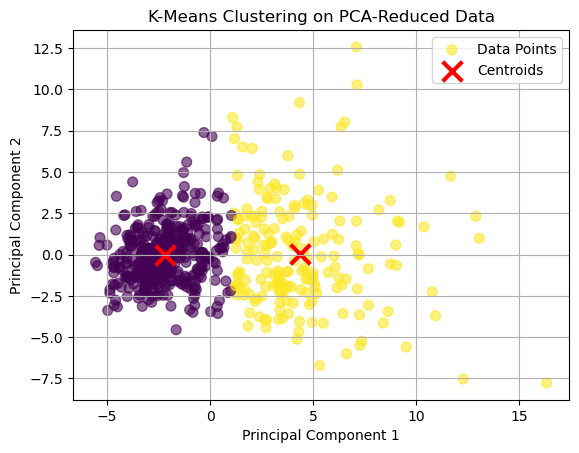

In [24]:
kmeans = Kmeans(k=2, max_iter=100)
kmeans.fit(X_projected)
labels = kmeans.predict(X_projected)
centrodis = kmeans.centroids


plt.scatter(
    X_projected[:, 0],
    X_projected[:, 1],
    c=labels,
    cmap="viridis",
    s=50,
    alpha=0.6,
    label="Data Points",
)
plt.scatter(
    centrodis[:, 0],
    centrodis[:, 1],
    c="red",
    marker="x",
    s=200,
    linewidths=3,
    label="Centroids",
)

plt.title("K-Means Clustering on PCA-Reduced Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

## 4. Impact of Number of Components

Testing PCA with different numbers of components (2, 5, 10, 15, 20) to analyze the trade-off between information preservation (Variance) and Reconstruction Error.


N_Components    | Preserved Var (%)    | Reconstruction Error
-----------------------------------------------------------------
2               | 63.24                | 809.7928            
5               | 84.73                | 729.8173            
10              | 95.16                | 515.5582            
15              | 98.65                | 249.0515            
20              | 99.56                | 51.4036             


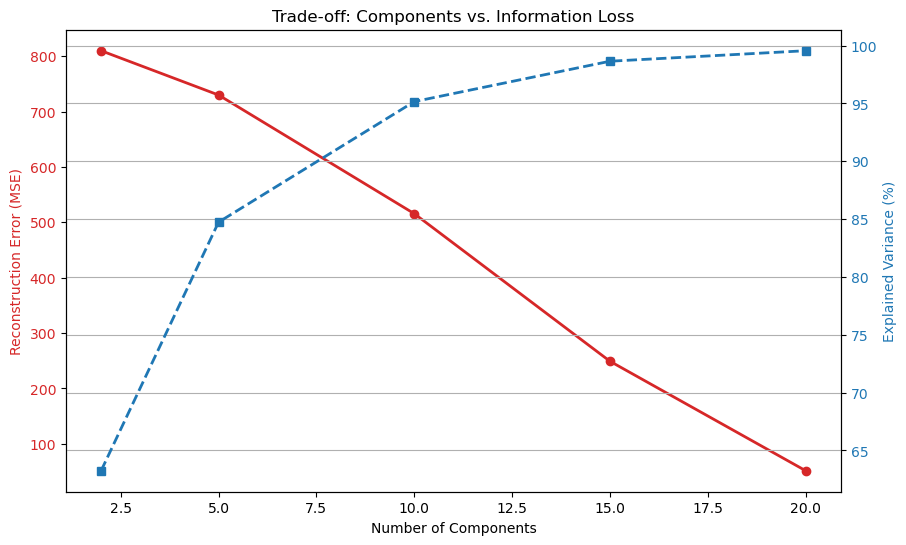

In [25]:
components_counts = [2, 5, 10, 15, 20]
errors = []
variances = []

print(
    f"{'N_Components':<15} | {'Preserved Var (%)':<20} | {'Reconstruction Error':<20}"
)
print("-" * 65)

for com in components_counts:
    pca = ManualPCA(n_components=com)
    X_projected = pca.fit_transform(X)
    X_reconstructed = pca.inverse_transform(X_projected)
    current_error = pca.compute_reconstruction_error(X, X_projected)
    variance = (
        np.sum(pca.explained_variance_ratio) * 100
    )  # pca.explained_variance_ratio_.sum() * 100
    errors.append(current_error)
    variances.append(variance)
    print(f"{com:<15} | {variance:<20.2f} | {current_error:<20.4f}")


# Plotting the trade-off
fig, ax1 = plt.subplots(figsize=(10, 6))

color = "tab:red"
ax1.set_xlabel("Number of Components")
ax1.set_ylabel("Reconstruction Error (MSE)", color=color)
ax1.plot(components_counts, errors, marker="o", color=color, linewidth=2, label="Error")
ax1.tick_params(axis="y", labelcolor=color)


ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel("Explained Variance (%)", color=color)
ax2.plot(
    components_counts,
    variances,
    marker="s",
    linestyle="--",
    color=color,
    linewidth=2,
    label="Variance",
)
ax2.tick_params(axis="y", labelcolor=color)

plt.title("Trade-off: Components vs. Information Loss")
plt.grid(True)
plt.show()

## 5. Dimensionality vs. Clustering Quality

Analyzing how the number of PCA components affects the clustering quality (ARI and Silhouette Score) compared to the baseline (original data).


N_Components    | Adjusted Rand Index (ARI) | Silhouette Score    
----------------------------------------------------------------------
2               | 0.6592               | 0.5085              
5               | 0.6709               | 0.3909              
10              | 0.6765               | 0.3577              
15              | 0.6765               | 0.3481              
20              | 0.6594               | 0.3438              
Full Data KMeans | 0.4914               | 0.6973              


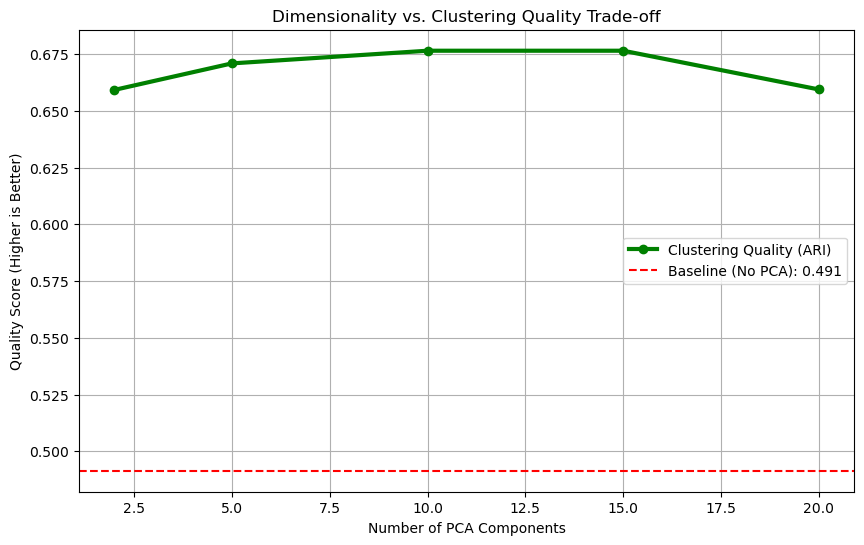

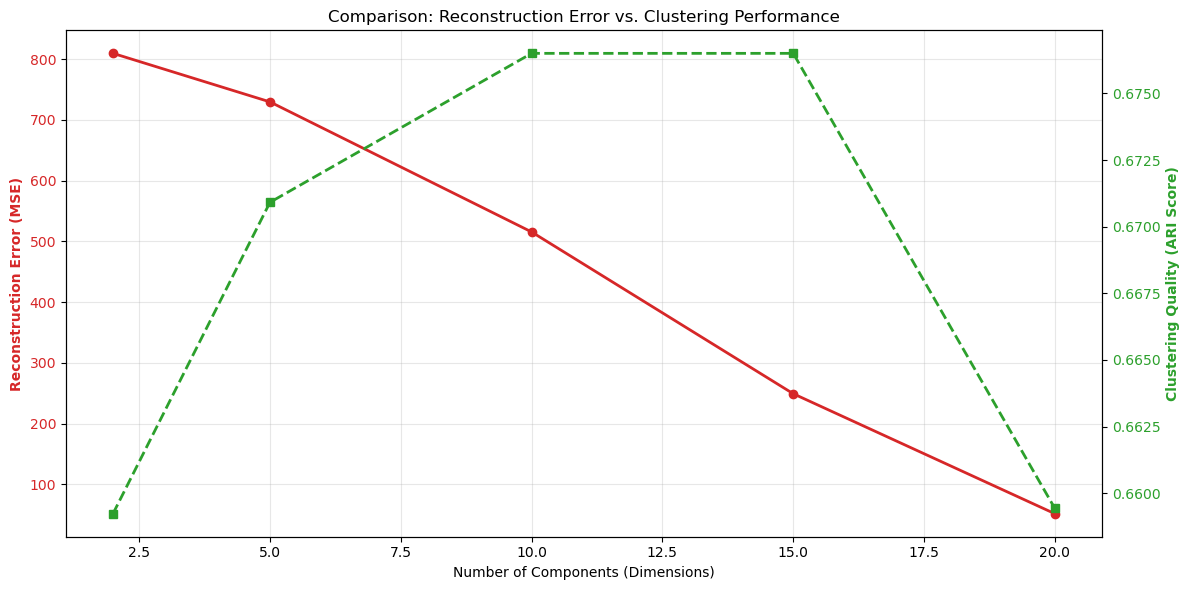

In [ ]:
ari_scores = []
silhouette_scores = []


print(
    f"{'N_Components':<15} | {'Adjusted Rand Index (ARI)':<20} | {'Silhouette Score':<20}"
)
print("-" * 70)
for com in components_counts:
    # A. PCA Step: Reduce dimensionality to 'com' components
    # Reducing dimensions helps K-Means by mitigating the "curse of dimensionality" and focusing on variance.
    pca = ManualPCA(n_components=com)
    X_projected = pca.fit_transform(X)

    # B. K-Means Clustering:
    # Initialize K-Means with k=2 (since we know there are 2 classes: Malignant/Benign)
    kmeans = Kmeans(k=2, max_iter=100)
    
    # Fit the model: Iteratively updates centroids to minimize within-cluster variance
    kmeans.fit(X_projected)
    
    # Predict labels: Assign each point to the nearest centroid
    labels = kmeans.predict(X_projected)
    
    # C. Evaluation:
    # ARI: Measures similarity between predicted clusters and true labels (External Metric)
    ari = adjusted_rand_score(y, labels)
    ari_scores.append(ari)
    
    # Silhouette Score: Measures how similar an object is to its own cluster compared to other clusters (Internal Metric)
    silhouette = silhouette_score(X_projected, labels)
    silhouette_scores.append(silhouette)
    print(f"{com:<15} | {ari:<20.4f} | {silhouette:<20.4f}")

# Plotting the clustering metrics
plt.figure(figsize=(10, 6))
plt.plot(
    components_counts,
    ari_scores,
    marker="o",
    linewidth=3,
    color="green",
    label="Clustering Quality (ARI)",
)


# compare with full kmeans on original data
kmeans_full = Kmeans(k=2, max_iter=100)
kmeans_full.fit(X)
labels_full = kmeans_full.predict(X)
ari_full = adjusted_rand_score(y, labels_full)
silhouette_full = silhouette_score(X, labels_full)
print(f"Full Data KMeans | {ari_full:<20.4f} | {silhouette_full:<20.4f}")
plt.axhline(
    y=ari_full, color="red", linestyle="--", label=f"Baseline (No PCA): {ari_full:.3f}"
)


plt.title("Dimensionality vs. Clustering Quality Trade-off")
plt.xlabel("Number of PCA Components")
plt.ylabel("Quality Score (Higher is Better)")
plt.legend()
plt.grid(True)
plt.show()


fig, ax1 = plt.subplots(figsize=(12, 6))

color = "tab:red"
ax1.set_xlabel("Number of Components (Dimensions)")
ax1.set_ylabel("Reconstruction Error (MSE)", color=color, fontweight="bold")
ax1.plot(
    components_counts,
    errors,
    color=color,
    marker="o",
    linestyle="-",
    linewidth=2,
    label="PCA Error (Lower is better)",
)
ax1.tick_params(axis="y", labelcolor=color)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
color = "tab:green"
ax2.set_ylabel("Clustering Quality (ARI Score)", color=color, fontweight="bold")
ax2.plot(
    components_counts,
    ari_scores,
    color=color,
    marker="s",
    linestyle="--",
    linewidth=2,
    label="Clustering Quality (Higher is better)",
)
ax2.tick_params(axis="y", labelcolor=color)


plt.title("Comparison: Reconstruction Error vs. Clustering Performance")
fig.tight_layout()
plt.show()

## 6. Conclusion: K-Means after PCA

### Key Findings:

1. **Dimensionality Reduction & Performance**: Applying PCA before K-Means can significantly reduce computational complexity while maintaining (or sometimes improving) clustering performance.
2. **Noise Reduction**: Lower dimensions (e.g., 2 or 5 components) often capture the main structure of the data while filtering out noise, which can lead to better separation of clusters.
3. **Trade-off**:
   - **Too few components** (high reconstruction error) might lose critical information needed for separation.
   - **Too many components** might re-introduce noise and the "curse of dimensionality," potentially degrading K-Means performance.
4. **Optimal Balance**: The charts above help identify the "sweet spot" where we retain enough variance (low error) to represent the data accurately while keeping dimensions low enough for efficient and effective clustering.


# Experiment 4: GMM Clustering after PCA

## 7. Impact of Dimensionality on Covariance Types

Testing Gaussian Mixture Models (GMM) with different covariance types (`full`, `tied`, `diag`, `spherical`) across various PCA dimensions to observe how dimensionality affects model performance.


Dim   | Full       | Tied       | Diag       | Spherical 
-------------------------------------------------------
2     | 0.6268     | 0.3866     | 0.6324     | 0.6156    
3     | 0.5991     | 0.3447     | 0.5994     | 0.6045    
5     | 0.7928     | 0.3266     | 0.4520     | 0.6038    
10    | 0.5962     | 0.3496     | 0.0437     | 0.5610    
15    | 0.8180     | 0.3311     | 0.0730     | 0.5661    
20    | 0.6640     | 0.0439     | 0.0544     | 0.5609    
20    | 0.6640     | 0.0439     | 0.0544     | 0.5609    


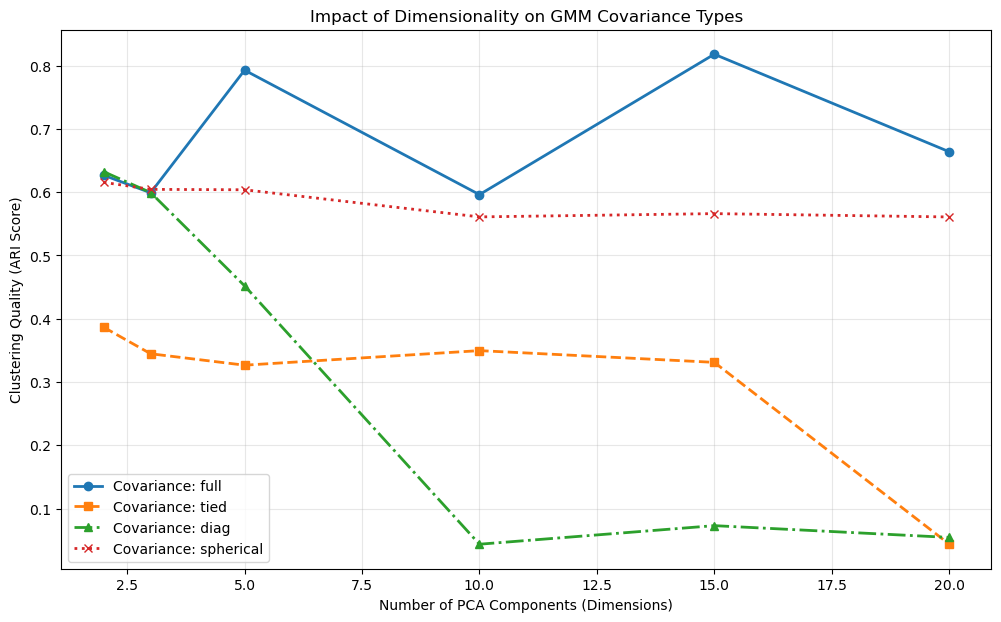

In [ ]:
dimensions = [2, 3, 5, 10, 15, 20]
cov_types = ["full", "tied", "diag", "spherical"]
results = {ctype: [] for ctype in cov_types}


print(f"{'Dim':<5} | {'Full':<10} | {'Tied':<10} | {'Diag':<10} | {'Spherical':<10}")
print("-" * 55)


for k in dimensions:
    # A. PCA Step: Reduce dimensionality to 'k' components
    # This reduces the feature space, potentially removing noise and helping GMM converge better.
    pca = ManualPCA(n_components=k)
    X_pca = pca.fit_transform(X)

    current_scores = []

    # B. Loop over Covariance Types: Test different constraints on cluster shapes
    # - 'full': Flexible, each cluster has its own shape/orientation.
    # - 'tied': All clusters share the same shape/orientation.
    # - 'diag': Clusters are axis-aligned ellipses.
    # - 'spherical': Clusters are spherical.
    for ctype in cov_types:
        try:

            gmm = GaussianMixtureModel(
                n_components=2, covariance_type=ctype, max_iter=100, random_state=42
            )
            # Fit the model using the EM algorithm (Expectation-Maximization)
            gmm.fit(X_pca)

            # Predict labels:
            # 1. Compute posterior probabilities (responsibilities) for each point belonging to each cluster
            probs, _ = gmm._e_step(X_pca)
            # 2. Assign point to the cluster with the highest probability (Hard Clustering)
            labels = np.argmax(probs, axis=1)

            # Calculate Adjusted Rand Index (ARI) to compare predicted clusters with true labels
            score = adjusted_rand_score(y, labels)
            results[ctype].append(score)
            current_scores.append(score)

        except Exception as e:
            # Handle potential numerical instabilities (e.g., singular covariance matrices)
            results[ctype].append(0)
            current_scores.append(0)
    print(
        f"{k:<5} | {current_scores[0]:<10.4f} | {current_scores[1]:<10.4f} | {current_scores[2]:<10.4f} | {current_scores[3]:<10.4f}"
    )

plt.figure(figsize=(12, 7))

markers = {"full": "o", "tied": "s", "diag": "^", "spherical": "x"}
linestyles = {"full": "-", "tied": "--", "diag": "-.", "spherical": ":"}

for ctype in cov_types:
    plt.plot(
        dimensions,
        results[ctype],
        marker=markers[ctype],
        linestyle=linestyles[ctype],
        linewidth=2,
        label=f"Covariance: {ctype}",
    )

plt.title("Impact of Dimensionality on GMM Covariance Types")
plt.xlabel("Number of PCA Components (Dimensions)")
plt.ylabel("Clustering Quality (ARI Score)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 8. Conclusion: GMM after PCA

### Key Observations:
1. **Covariance Types**: 
   - **Full**: Generally performs well but requires more parameters. As dimensions increase, it might struggle if data is insufficient.
   - **Diag/Spherical**: More constrained. They might perform worse if the true clusters have complex shapes, but are more robust in high dimensions with limited data.
   - **Tied**: Shares covariance across clusters, which can be a good regularizer.
2. **Dimensionality**: Similar to K-Means, there is often a peak performance at lower dimensions (e.g., 2-5 components) where noise is reduced but signal is preserved.